In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import math, time, random, datetime

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [4]:
train.isnull().any()
# Age, Cabin, Embarked

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
con_df = pd.DataFrame() # Continuous. No separate containers
bin_df = pd.DataFrame() # Sorting into separate containers based on a feature's value

<AxesSubplot:xlabel='count', ylabel='Survived'>

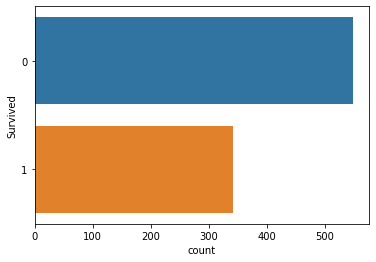

In [6]:
var = "Survived"

con_df[var] = train[var]

sns.countplot(y=train[var])

In [7]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [8]:
con_df.head()

Survived
0         0
1         1
2         1
3         1
4         0

<AxesSubplot:xlabel='count', ylabel='Pclass'>

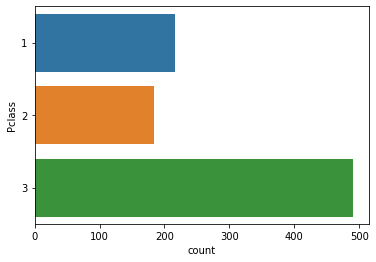

In [9]:
var = "Pclass"

con_df[var] = train[var]

sns.countplot(y=train[var])

In [10]:
class1 = train.loc[train.Pclass == 1]["Survived"]
rate_class = sum(class1)/len(class1)

class2 = train.loc[train.Pclass == 2]["Survived"]
rate_class2 = sum(class2)/len(class2)

class3 = train.loc[train.Pclass == 3]["Survived"]
rate_class3 = sum(class3)/len(class3)

print("% of 1st classers who survived:", rate_class)
print("% of 2nd classers who survived:", rate_class2)
print("% of 3rd classers who survived:", rate_class3)

% of 1st classers who survived: 0.6296296296296297
% of 2nd classers who survived: 0.47282608695652173
% of 3rd classers who survived: 0.24236252545824846


In [11]:
var = "Name"
train[var].value_counts()

# con_df[var] = train[var]

name_title = pd.Series([])
test_title = pd.Series([])

i = -1
for name in train[var]:
    # print(name)
    i+=1      
    if "Mr." in name:
        # Case 1
        name_title[i] = "Mr."
        test_title[i] = "Mr."
        
    elif "Mrs." in name:
        # Case 2
        name_title[i] = "Mrs."
        test_title[i] = "Mrs."
        
    elif "Miss." in name:
        # Case 3
        name_title[i] = "Miss."
        test_title[i] = "Miss."
        
    elif "Dr." in name:
        # Case 4
        name_title[i] = "Dr."
        test_title[i] = "Dr."
        
    else:
        # Case 5
        name_title[i] = "Etc."
        test_title[i] = "Etc."

#con_df

In [12]:
con_df.insert(2,"Title",name_title)
test.insert(2,"Title",test_title)

In [13]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [14]:
con_df.head()

Survived  Pclass  Title
0         0       3    Mr.
1         1       1   Mrs.
2         1       3  Miss.
3         1       1   Mrs.
4         0       3    Mr.

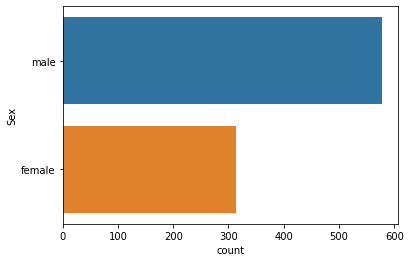

In [15]:
var = "Sex"

sns.countplot(y=train[var])

con_df[var] = train[var]

In [16]:
con_df.head()

Survived  Pclass  Title     Sex
0         0       3    Mr.    male
1         1       1   Mrs.  female
2         1       3  Miss.  female
3         1       1   Mrs.  female
4         0       3    Mr.    male

In [17]:
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


<AxesSubplot:ylabel='Age'>

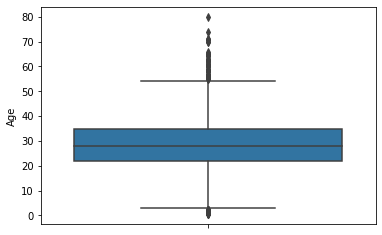

In [18]:
var = "Age"
nullToMedian = train[var].fillna(train[var].median())
train[var] = nullToMedian

con_df[var] = train[var]

sns.boxplot(y=train[var])

In [19]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [20]:
con_df.head()

Survived  Pclass  Title     Sex   Age
0         0       3    Mr.    male  22.0
1         1       1   Mrs.  female  38.0
2         1       3  Miss.  female  26.0
3         1       1   Mrs.  female  35.0
4         0       3    Mr.    male  35.0

In [21]:
child = train.loc[train.Age < 18]["Survived"]
rate_child = sum(child)/len(child)

adult = train.loc[train.Age >= 18]["Survived"]
#adult = train.loc[train.Age < 70]["Survived"]
rate_adult = sum(adult)/len(adult)

elder = train.loc[train.Age >= 70]["Survived"]
rate_elder = sum(elder)/len(elder)

print("% of children who survived:", rate_child)
print("% of adults who survived:", rate_adult)
print("% of elders who survived:", rate_elder)

% of children who survived: 0.5398230088495575
% of adults who survived: 0.36118251928020567
% of elders who survived: 0.14285714285714285


<AxesSubplot:xlabel='count', ylabel='SibSp'>

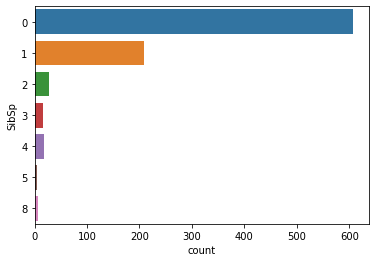

In [22]:
var = "SibSp"
con_df[var] = train[var]
sns.countplot(y=train[var])

<AxesSubplot:xlabel='count', ylabel='Parch'>

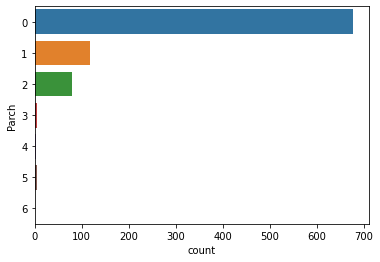

In [23]:
var = "Parch"
con_df[var] = train[var]
sns.countplot(y=train[var])

In [24]:
var = "Ticket"

ticket_type = pd.Series([])
test_ticket = pd.Series([])

i = -1
for ticket in train[var]:
    # print(ticket)
    i+=1
    if ticket.isnumeric():
        ticket_type[i] = "regular"
        test_ticket[i] = "regular"
        
    else:
        # case 2
        ticket_type[i] = "special"
        test_ticket[i] = "special"

# train.Ticket.value_counts()

In [25]:
con_df.insert(2,"Ticket Type",ticket_type)
test.insert(2,"Ticket Type",test_ticket)

In [26]:
con_df.head()

Survived  Pclass Ticket Type  Title     Sex   Age  SibSp  Parch
0         0       3     special    Mr.    male  22.0      1      0
1         1       1     special   Mrs.  female  38.0      1      0
2         1       3     special  Miss.  female  26.0      0      0
3         1       1     regular   Mrs.  female  35.0      1      0
4         0       3     regular    Mr.    male  35.0      0      0

In [27]:
var = "Fare"
# sns.boxplot(y=train[var])
con_df[var] = train[var]
bin_df[var] = pd.cut(train[var], bins = 5)

train[var].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [28]:
var = "Cabin"
train = train[ ~pd.isnull(train.Cabin)]
train.reset_index(drop=True,inplace=True)

cabin_letter = pd.Series([])
test_cabin = pd.Series([])

i = -1
for cabin in train[var]:
    # print(cabin)
    i+=1
    if cabin.startswith("A"):
        cabin_letter[i] = "A"
        test_cabin[i] = "A"
              
    elif cabin.startswith("B"):
        cabin_letter[i] = "B"
        test_cabin[i] = "B"
        
    elif cabin.startswith("C"):
        cabin_letter[i] = "C"
        test_cabin[i] = "C"
        
    elif cabin.startswith("D"):
        cabin_letter[i] = "D"
        test_cabin[i] = "D"
        
    elif cabin.startswith("E"):
        cabin_letter[i] = "E"
        test_cabin[i] = "E"
        
    elif cabin.startswith("F"):
        cabin_letter[i] = "F"
        test_cabin[i] = "F"
        
    elif cabin.startswith("G"):
        cabin_letter[i] = "G"
        test_cabin[i] = "G"
    
    else:
        cabin_letter[i] = "Special"
        test_cabin[i] = "Special"

con_df.head()

Survived  Pclass Ticket Type  Title     Sex   Age  SibSp  Parch     Fare
0         0       3     special    Mr.    male  22.0      1      0   7.2500
1         1       1     special   Mrs.  female  38.0      1      0  71.2833
2         1       3     special  Miss.  female  26.0      0      0   7.9250
3         1       1     regular   Mrs.  female  35.0      1      0  53.1000
4         0       3     regular    Mr.    male  35.0      0      0   8.0500

In [29]:
con_df.insert(5,"Cabin Letter",cabin_letter)
test.insert(5,"Cabin Letter",test_cabin)

<AxesSubplot:xlabel='count', ylabel='Cabin Letter'>

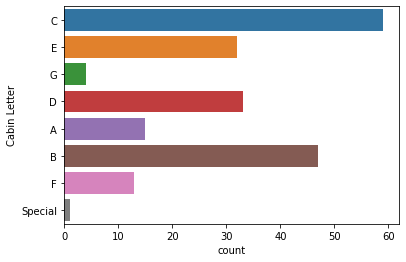

In [30]:
con_df.reset_index(drop=True,inplace=True)

sns.countplot(y=con_df["Cabin Letter"])

In [31]:
con_df.head(20)

Survived  Pclass Ticket Type  Title     Sex Cabin Letter   Age  SibSp  \
0          0       3     special    Mr.    male            C  22.0      1   
1          1       1     special   Mrs.  female            C  38.0      1   
2          1       3     special  Miss.  female            E  26.0      0   
3          1       1     regular   Mrs.  female            G  35.0      1   
4          0       3     regular    Mr.    male            C  35.0      0   
5          0       3     regular    Mr.    male            D  28.0      0   
6          0       1     regular    Mr.    male            A  54.0      0   
7          0       3     regular   Etc.    male            C   2.0      3   
8          1       3     regular   Mrs.  female            B  27.0      0   
9          1       2     regular   Mrs.  female            D  14.0      1   
10         1       3     special  Miss.  female            B   4.0      1   
11         1       1     regular  Miss.  female            C  58.0      0   
12         0       3     special    Mr.    male            B  20.0      0   
13         0       3     regular    Mr.    male            C  39.0      1   
14         0       3     regular  Miss.  female            F  14.0      0   
15         1       2     regular   Mrs.  female            F  55.0      0   
16         0       3     regular   Etc.    male            C   2.0      4   
17         1       2     regular    Mr.    male            E  28.0      0   
18         0       3     regular   Mrs.  female            A  31.0      1   
19         1       3     regular   Mrs.  female            D  28.0      0   

    Parch     Fare  
0       0   7.2500  
1       0  71.2833  
2       0   7.9250  
3       0  53.1000  
4       0   8.0500  
5       0   8.4583  
6       0  51.8625  
7       1  21.0750  
8       2  11.1333  
9       0  30.0708  
10      1  16.7000  
11      0  26.5500  
12      0   8.0500  
13      5  31.2750  
14      0   7.8542  
15      0  16.0000  
16      1  29.1250  
17      0  13.0000  
18      0  18.0000  
19      0   7.2250

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

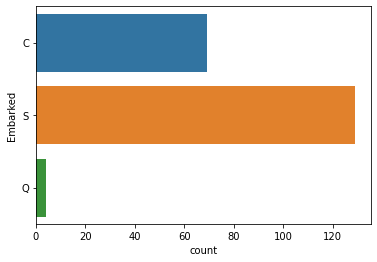

In [32]:
var = "Embarked"
train = train[ ~pd.isnull(train.Embarked)]
train.reset_index(inplace=True, drop=True)

con_df[var] = train[var]

sns.countplot(y=train[var])

train.isnull().any()
# No more null values for train

In [33]:
con_df.isnull().any()

Survived        False
Pclass          False
Ticket Type     False
Title           False
Sex             False
Cabin Letter     True
Age             False
SibSp           False
Parch           False
Fare            False
Embarked         True
dtype: bool

In [34]:
con_df.shape

(891, 11)

In [35]:
con_df = con_df[ ~pd.isnull(con_df["Cabin Letter"])]
con_df = con_df[ ~pd.isnull(con_df["Embarked"])]

con_df.reset_index(inplace=True, drop=True)

con_df.shape

(202, 11)

In [36]:
df_ticket_one_hot = pd.get_dummies(con_df['Ticket Type'], 
                                     prefix='ticket type')

df_title_one_hot = pd.get_dummies(con_df['Title'], 
                                     prefix='title')

df_cabin_one_hot = pd.get_dummies(con_df['Cabin Letter'], 
                                     prefix='cabin letter')

df_embarked_one_hot = pd.get_dummies(con_df['Embarked'], 
                                     prefix='embarked')

df_pclass_one_hot = pd.get_dummies(con_df['Pclass'], 
                                     prefix='pclass')

df_sex_one_hot = pd.get_dummies(con_df['Sex'], 
                                     prefix='sex')

concat_df = pd.concat([con_df,
                       df_ticket_one_hot,
                       df_title_one_hot,
                       df_cabin_one_hot,
                       df_embarked_one_hot,
                       df_pclass_one_hot,
                       df_sex_one_hot]
                      ,axis=1)


pd.set_option('display.max_columns', 1000)
concat_df = concat_df.drop(['Ticket Type','Title','Cabin Letter','Pclass','Sex','Embarked'], axis=1)
concat_df.head(10)


Survived   Age  SibSp  Parch     Fare  ticket type_regular  \
0         0  22.0      1      0   7.2500                    0   
1         1  38.0      1      0  71.2833                    0   
2         1  26.0      0      0   7.9250                    0   
3         1  35.0      1      0  53.1000                    1   
4         0  35.0      0      0   8.0500                    1   
5         0  28.0      0      0   8.4583                    1   
6         0  54.0      0      0  51.8625                    1   
7         0   2.0      3      1  21.0750                    1   
8         1  27.0      0      2  11.1333                    1   
9         1  14.0      1      0  30.0708                    1   

   ticket type_special  title_Etc.  title_Miss.  title_Mr.  title_Mrs.  \
0                    1           0            0          1           0   
1                    1           0            0          0           1   
2                    1           0            1          0           0   
3                    0           0            0          0           1   
4                    0           0            0          1           0   
5                    0           0            0          1           0   
6                    0           0            0          1           0   
7                    0           1            0          0           0   
8                    0           0            0          0           1   
9                    0           0            0          0           1   

   cabin letter_A  cabin letter_B  cabin letter_C  cabin letter_D  \
0               0               0               1               0   
1               0               0               1               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               1               0   
5               0               0               0               1   
6               1               0               0               0   
7               0               0               1               0   
8               0               1               0               0   
9               0               0               0               1   

   cabin letter_E  cabin letter_F  cabin letter_G  cabin letter_Special  \
0               0               0               0                     0   
1               0               0               0                     0   
2               1               0               0                     0   
3               0               0               1                     0   
4               0               0               0                     0   
5               0               0               0                     0   
6               0               0               0                     0   
7               0               0               0                     0   
8               0               0               0                     0   
9               0               0               0                     0   

   embarked_C  embarked_Q  embarked_S  pclass_1  pclass_2  pclass_3  \
0           1           0           0         0         0         1   
1           0           0           1         1         0         0   
2           0           0           1         0         0         1   
3           0           0           1         1         0         0   
4           0           0           1         0         0         1   
5           0           0           1         0         0         1   
6           0           0           1         1         0         0   
7           0           0           1         0         0         1   
8           1           0           0         0         0         1   
9           1           0           0         0         1         0   

   sex_female  sex_male  
0           0         1  
1           1         0  
2           1         0  


In [37]:
selected_df = concat_df

X_train = selected_df.drop('Survived', axis=1)
y_train = selected_df.Survived 

In [38]:
X_train.head(20)

Age  SibSp  Parch     Fare  ticket type_regular  ticket type_special  \
0   22.0      1      0   7.2500                    0                    1   
1   38.0      1      0  71.2833                    0                    1   
2   26.0      0      0   7.9250                    0                    1   
3   35.0      1      0  53.1000                    1                    0   
4   35.0      0      0   8.0500                    1                    0   
5   28.0      0      0   8.4583                    1                    0   
6   54.0      0      0  51.8625                    1                    0   
7    2.0      3      1  21.0750                    1                    0   
8   27.0      0      2  11.1333                    1                    0   
9   14.0      1      0  30.0708                    1                    0   
10   4.0      1      1  16.7000                    0                    1   
11  58.0      0      0  26.5500                    1                    0   
12  20.0      0      0   8.0500                    0                    1   
13  39.0      1      5  31.2750                    1                    0   
14  14.0      0      0   7.8542                    1                    0   
15  55.0      0      0  16.0000                    1                    0   
16   2.0      4      1  29.1250                    1                    0   
17  28.0      0      0  13.0000                    1                    0   
18  31.0      1      0  18.0000                    1                    0   
19  28.0      0      0   7.2250                    1                    0   

    title_Etc.  title_Miss.  title_Mr.  title_Mrs.  cabin letter_A  \
0            0            0          1           0               0   
1            0            0          0           1               0   
2            0            1          0           0               0   
3            0            0          0           1               0   
4            0            0          1           0               0   
5            0            0          1           0               0   
6            0            0          1           0               1   
7            1            0          0           0               0   
8            0            0          0           1               0   
9            0            0          0           1               0   
10           0            1          0           0               0   
11           0            1          0           0               0   
12           0            0          1           0               0   
13           0            0          1           0               0   
14           0            1          0           0               0   
15           0            0          0           1               0   
16           1            0          0           0               0   
17           0            0          1           0               0   
18           0            0          0           1               1   
19           0            0          0           1               0   

    cabin letter_B  cabin letter_C  cabin letter_D  cabin letter_E  \
0                0               1               0               0   
1                0               1               0               0   
2                0               0               0               1   
3                0               0               0               0   
4                0               1               0               0   
5                0               0               1               0   
6                0               0               0               0   
7                0               1               0               0   
8                1               0               0               0   
9                0               0               1               0   
10               1               0               0               0   
11               0               1               0               0   
12    

In [39]:
# Function that runs the requested algorithm and returns the accuracy metrics
# Credit: Daniel Bourke -- https://github.com/mrdbourke/your-first-kaggle-submission/blob/master/kaggle-titanic-dataset-example-submission-workflow.ipynb
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [40]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 86.63
Accuracy CV 10-Fold: 81.19
Running Time: 0:00:01.903766


In [41]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 78.71
Accuracy CV 10-Fold: 62.87
Running Time: 0:00:00.146832


In [42]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 83.17
Accuracy CV 10-Fold: 80.2
Running Time: 0:00:00.060153


In [43]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 73.76
Accuracy CV 10-Fold: 71.29
Running Time: 0:00:00.093259


In [44]:
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 66.34
Accuracy CV 10-Fold: 67.82
Running Time: 0:00:00.059012


In [45]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 71.78
Running Time: 0:00:00.075943


In [46]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 98.51
Accuracy CV 10-Fold: 78.71
Running Time: 0:00:00.486072


In [47]:
# XGBoosting Classifier
start_time = time.time()
train_pred_xgb, acc_xgb, acc_cv_xgb = fit_ml_algo(xgb.XGBRFClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
xgb_time = (time.time() - start_time)
print("Accuracy: %s" % acc_xgb)
print("Accuracy CV 10-Fold: %s" % acc_cv_xgb)
print("Running Time: %s" % datetime.timedelta(seconds=xgb_time))

Accuracy: 89.6
Accuracy CV 10-Fold: 80.69
Running Time: 0:00:01.287037


In [48]:
# Cat Boosting
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

In [49]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [50]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.005204
0:	learn: 0.6901340	total: 56.5ms	remaining: 56.4s
1:	learn: 0.6868479	total: 59ms	remaining: 29.4s
2:	learn: 0.6840212	total: 61.4ms	remaining: 20.4s
3:	learn: 0.6812579	total: 63.7ms	remaining: 15.9s
4:	learn: 0.6785084	total: 65ms	remaining: 12.9s
5:	learn: 0.6756908	total: 66.6ms	remaining: 11s
6:	learn: 0.6732016	total: 67.2ms	remaining: 9.54s
7:	learn: 0.6703512	total: 68.1ms	remaining: 8.45s
8:	learn: 0.6675247	total: 70.5ms	remaining: 7.76s
9:	learn: 0.6649559	total: 71.6ms	remaining: 7.09s
10:	learn: 0.6617847	total: 73ms	remaining: 6.56s
11:	learn: 0.6593864	total: 73.9ms	remaining: 6.09s
12:	learn: 0.6571527	total: 74.5ms	remaining: 5.66s
13:	learn: 0.6543669	total: 76.4ms	remaining: 5.38s
14:	learn: 0.6517999	total: 77.5ms	remaining: 5.09s
15:	learn: 0.6493819	total: 79.1ms	remaining: 4.86s
16:	learn: 0.6472108	total: 79.5ms	remaining: 4.6s
17:	learn: 0.6449958	total: 80.3ms	remaining: 4.38s
18:	learn: 0.6426868	total: 81.6ms	remaining: 4.21s
1

In [51]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6740457	test: 0.6816040	best: 0.6816040 (0)	total: 4.41ms	remaining: 4.4s
1:	learn: 0.6558953	test: 0.6697793	best: 0.6697793 (1)	total: 7.66ms	remaining: 3.82s
2:	learn: 0.6384178	test: 0.6608857	best: 0.6608857 (2)	total: 11.8ms	remaining: 3.9s
3:	learn: 0.6215802	test: 0.6527344	best: 0.6527344 (3)	total: 16.4ms	remaining: 4.09s
4:	learn: 0.6081585	test: 0.6460436	best: 0.6460436 (4)	total: 19ms	remaining: 3.79s
5:	learn: 0.5914561	test: 0.6453864	best: 0.6453864 (5)	total: 22.7ms	remaining: 3.76s
6:	learn: 0.5760327	test: 0.6385253	best: 0.6385253 (6)	total: 25.8ms	remaining: 3.66s
7:	learn: 0.5632705	test: 0.6306458	best: 0.6306458 (7)	total: 28.6ms	remaining: 3.55s
8:	learn: 0.5512266	test: 0.6272295	best: 0.6272295 (8)	total: 31.7ms	remaining: 3.49s
9:	learn: 0.5408204	test: 0.6240188	best: 0.6240188 (9)	total: 34.3ms	remaining: 3.4s
10:	learn: 0.5319288	test: 0.6188486	best: 0.6188486 (10)	total: 35.6ms	remaining: 3.2s
11:	learn: 0.5192020	te

In [52]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 88.61
Accuracy cross-validation 10-Fold: 82.66
Running Time: 0:00:33.940638


In [53]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees', 'XGBoost',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_xgb,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model   Score
5               Decision Tree  100.00
6     Gradient Boosting Trees   98.51
7                     XGBoost   89.60
8                    CatBoost   88.61
1         Logistic Regression   86.63
2                 Naive Bayes   83.17
0                         KNN   78.71
4                  Linear SVC   73.76
3  Stochastic Gradient Decent   66.34

In [54]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'XGBoost',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_xgb,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
8                    CatBoost  82.66
1         Logistic Regression  81.19
7                     XGBoost  80.69
2                 Naive Bayes  80.20
6     Gradient Boosting Trees  78.71
5               Decision Tree  71.78
4                  Linear SVC  71.29
3  Stochastic Gradient Decent  67.82
0                         KNN  62.87

In [55]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, True]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

imp                   col
17   0.022978  cabin letter_Special
19   0.027408            embarked_Q
16   0.032186        cabin letter_G
15   0.174321        cabin letter_F
18   0.600020            embarked_C
21   0.689839              pclass_1
6    0.722595            title_Etc.
7    0.873361           title_Miss.
20   0.993509            embarked_S
9    1.037751            title_Mrs.
11   1.084958        cabin letter_B
5    1.088519   ticket type_special
4    1.196509   ticket type_regular
22   1.199855              pclass_2
14   1.208707        cabin letter_E
12   1.265422        cabin letter_C
10   1.931055        cabin letter_A
13   2.564445        cabin letter_D
23   4.334379              pclass_3
0    8.310031                   Age
3    9.301301                  Fare
24   9.844922            sex_female
2   10.552193                 Parch
25  11.560307              sex_male
8   14.492259             title_Mr.
1   14.891169                 SibSp

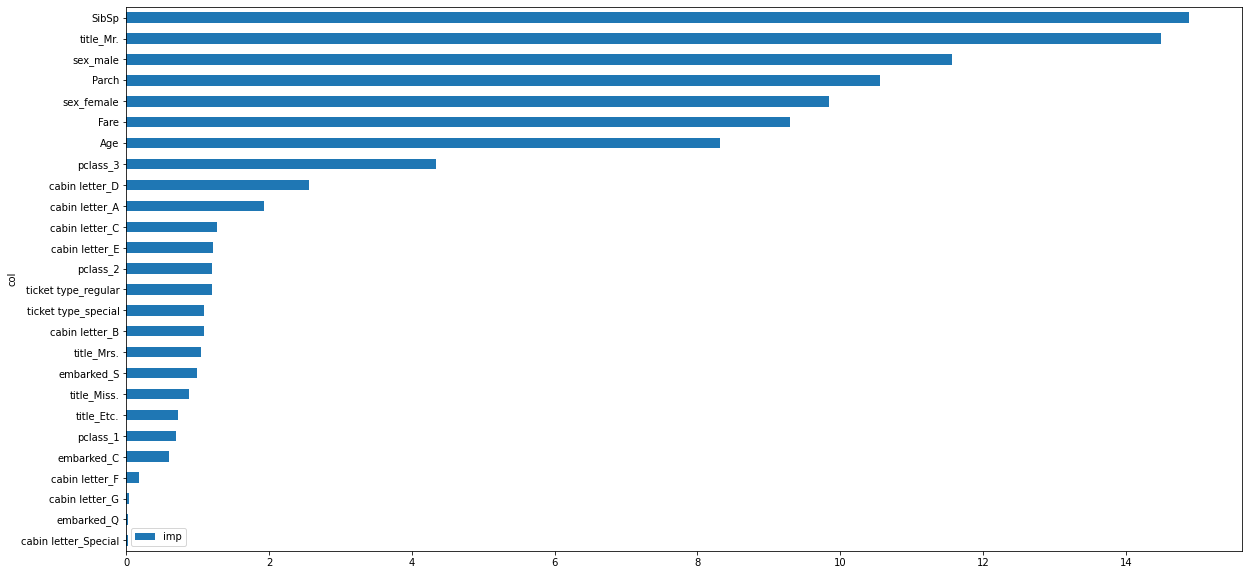

In [56]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

In [57]:
test_ticket_one_hot = pd.get_dummies(test['Ticket Type'], 
                                prefix='ticket type')

test_title_one_hot = pd.get_dummies(test['Title'], 
                                       prefix='title')

test_cabin_one_hot = pd.get_dummies(test['Cabin Letter'], 
                                   prefix='cabin letter')

test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_pclass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [58]:
test = pd.concat([test, 
                  test_ticket_one_hot,
                  test_title_one_hot,
                  test_cabin_one_hot,
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_pclass_one_hot], axis=1)

test.head()

PassengerId  Pclass Ticket Type  Title  \
0          892       3     special    Mr.   
1          893       3     special   Mrs.   
2          894       2     special  Miss.   
3          895       3     regular   Mrs.   
4          896       3     regular    Mr.   

                                           Name Cabin Letter     Sex   Age  \
0                              Kelly, Mr. James            C    male  34.5   
1              Wilkes, Mrs. James (Ellen Needs)            C  female  47.0   
2                     Myles, Mr. Thomas Francis            E    male  62.0   
3                              Wirz, Mr. Albert            G    male  27.0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)            C  female  22.0   

   SibSp  Parch   Ticket     Fare Cabin Embarked  ticket type_regular  \
0      0      0   330911   7.8292   NaN        Q                    0   
1      1      0   363272   7.0000   NaN        S                    0   
2      0      0   240276   9.6875   NaN        Q                    0   
3      0      0   315154   8.6625   NaN        S                    1   
4      1      1  3101298  12.2875   NaN        S                    1   

   ticket type_special  title_Dr.  title_Etc.  title_Miss.  title_Mr.  \
0                    1          0           0            0          1   
1                    1          0           0            0          0   
2                    1          0           0            1          0   
3                    0          0           0            0          0   
4                    0          0           0            0          1   

   title_Mrs.  cabin letter_A  cabin letter_B  cabin letter_C  cabin letter_D  \
0           0               0               0               1               0   
1           1               0               0               1               0   
2           0               0               0               0               0   
3           1               0               0               0               0   
4           0               0               0               1               0   

   cabin letter_E  cabin letter_F  cabin letter_G  cabin letter_Special  \
0               0               0               0                     0   
1               0               0               0                     0   
2               1               0               0                     0   
3               0               0               1                     0   
4               0               0               0                     0   

   embarked_C  embarked_Q  embarked_S  sex_female  sex_male  pclass_1  \
0           0           1           0           0         1         0   
1           0           0           1           1         0         0   
2           0           1           0           0         1         0   
3           0           0           1           0         1         0   
4           0           0           1           1         0         0   

   pclass_2  pclass_3  
0         0         1  
1         0         1  
2         1         0  
3         0         1  
4         0         1

In [59]:
X_train

Age  SibSp  Parch     Fare  ticket type_regular  ticket type_special  \
0    22.0      1      0   7.2500                    0                    1   
1    38.0      1      0  71.2833                    0                    1   
2    26.0      0      0   7.9250                    0                    1   
3    35.0      1      0  53.1000                    1                    0   
4    35.0      0      0   8.0500                    1                    0   
..    ...    ...    ...      ...                  ...                  ...   
197  42.0      0      1   8.4042                    1                    0   
198  28.0      0      0   7.7500                    1                    0   
199  24.0      0      0  13.0000                    1                    0   
200  28.0      0      0   9.5000                    1                    0   
201  28.0      8      2  69.5500                    0                    1   

     title_Etc.  title_Miss.  title_Mr.  title_Mrs.  cabin letter_A  \
0             0            0          1           0               0   
1             0            0          0           1               0   
2             0            1          0           0               0   
3             0            0          0           1               0   
4             0            0          1           0               0   
..          ...          ...        ...         ...             ...   
197           0            0          1           0               0   
198           0            1          0           0               1   
199           0            1          0           0               0   
200           0            0          1           0               0   
201           0            0          1           0               0   

     cabin letter_B  cabin letter_C  cabin letter_D  cabin letter_E  \
0                 0               1               0               0   
1                 0               1               0               0   
2                 0               0               0               1   
3                 0               0               0               0   
4                 0               1               0               0   
..              ...             ...             ...             ...   
197               0               0               1               0   
198               0               0               0               0   
199               0               0               1               0   
200               1               0               0               0   
201               0               1               0               0   

     cabin letter_F  cabin letter_G  cabin letter_Special  embarked_C  \
0                 0               0                     0           1   
1                 0               0                     0           0   
2                 0               0                     0           0   
3                 0               1                     0           0   
4                 0               0                     0           0   
..              ...             ...                   ...         ...   
197               0               0                     0           0   
198               0               0                     0           0   
199               0               0                     0           1   
200               0               0                     0           0   
201               0               0                     0           1   

     embarked_Q  embarked_S  pclass_1  pclass_2  pclass_3  sex_female  \
0             0           0         0         0         1           0   
1             0           1         1         0         0           1   
2             0           1         0         0         1           1   
3             0           1         1         0         0           1   
4             0           1         0         0         1           0   
..          ...         ...       ...       ... 

In [60]:
wanted_test_columns = X_train.columns

In [61]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [62]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0

In [63]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [64]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [65]:
read_submission = pd.read_csv("/kaggle/working/submission.csv")
read_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0